In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from tqdm import tqdm
tqdm.pandas()
import re
import time
from gensim.models import Word2Vec  # Word embeddings

In [3]:
# Load train data
df_train = pd.read_csv('../train.csv')
# Import test data
df_test = pd.read_csv('../test.csv')

In [4]:
## Augment titles like this
## augCap = 'startseq' + title +  'endseq'
def aug_title(inputs):
    impath =  inputs[0]
    title = inputs[1]
    
    path_segs = impath.split('/')
    path_map = {'beauty_image':'beu', 'fashion_image':'fas', 'mobile_image':'mob'}
    word_base = path_map[path_segs[0]]
    start = word_base + 'start' 
    end = word_base + 'end'
    
    augCap = start + ' ' +  title + ' ' + end
    
    return augCap
##
df_train['augCap'] = df_train.loc[:,['image_path','title']].apply(lambda x: aug_title(x),axis=1)
df_test['augCap'] = df_test.loc[:,['image_path','title']].apply(lambda x: aug_title(x),axis=1)

In [39]:
def update_file_path(inp):
    #print(inp)
    x = inp[0]
    cat = inp[1]
    path_segs = x.split('/')
    
    path_map = {'beauty_image':'Beauty', 'fashion_image':'Fashion', 'mobile_image':'Mobile'}
    base_path = 'Train/' + path_map[path_segs[0]]
    rel_path = path_segs[1]
    rel_segs = rel_path.split('.')
    if len(rel_segs) == 1:
        rel_path = rel_path + '.jpg'
    return base_path + '/' + str(cat)+ '/' + rel_path

df_train['new_path'] = df_train.loc[:,['image_path','Category']].apply(lambda x: update_file_path(x),axis=1)
df_train['meta_cat'] = df_train.loc[:,'image_path'].apply(lambda x: x.split('/')[0])

In [ ]:
## Update image location

In [5]:
# check how train set looks like
df_train.tail().augCap.values

array(['mobstart beli 2 gratis 1 xiaomi mi mix black 6 64 rom global official mobend',
       'mobstart android i phone x real 4g 16gb free wireless charger softcase berkualitas mobend',
       'mobstart xiaomi mia1 ram 4gb 64gb black mobend',
       'mobstart khusus hari ini samsung j2 prime mobend',
       'mobstart oppo a83 2 gb new garansi resmi 1 tahun mobend'],
      dtype=object)

In [6]:
# Load VGG-16 embeddings
# Read Image features
N_train = len(df_train)
img_train = np.memmap('../all_image_data.npy', dtype='float32', mode='r', shape=(N_train,4,4,512))
print('The shape of img_train: {}'.format(img_train.shape))

The shape of img_train: (666615, 4, 4, 512)


In [7]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab
#
sentences = df_train["augCap"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 666615/666615 [00:01<00:00, 398457.35it/s]

{'beustart': 286583, 'nyx': 8160, 'sex': 16, 'bomb': 35, 'pallete': 628}


In [8]:
print('The number of words in vocab = %d' % len(vocab))

The number of words in vocab = 84507


In [9]:
sen = df_train['augCap']
train_sentences = list(sen.progress_apply(str.split).values)

100%|██████████| 666615/666615 [00:03<00:00, 194368.28it/s]


In [14]:
train_sentences[0]

['beustart', 'nyx', 'sex', 'bomb', 'pallete', 'natural', 'palette', 'beuend']

In [15]:
# Build embeddings
# train word embeddings


start_time = time.time()

text_model = Word2Vec(min_count=5, window=3, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20)
text_model.build_vocab(sentences, progress_per=10000)


# text_model = Word2Vec(sentences=train_sentences, sg=1, window=3, size=300)
print('The number of word for which embeddings will be computed: %d' %len(text_model.wv.vocab))

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

The number of word for which embeddings will be computed: 19531
Time taken : 0.03 mins


In [16]:
# Train the word to vec model
start_time = time.time()

text_model.train(sentences = train_sentences, total_examples=text_model.corpus_count, epochs=30, report_delay=1)

# text_model.corpus_count

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 3.45 mins


In [17]:
# all_train_titles is contains not splited titles
all_train_titles = df_train.augCap.values

In [18]:
# (Not used here)
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_titles:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 84507 -> 19531


In [19]:
# Not used, we will use keras Tokenizer instead
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [20]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

19532

In [21]:
# Find maximum sequence length

temp_train = df_train.copy()
temp_train['words'] = temp_train['augCap'].apply(lambda x: x.split())
temp_train['numWord'] = temp_train['words'].apply(lambda x: len(x))

min_len = min(temp_train['numWord'])
print('The minimum number of words in a title: {}'.format(min_len))

max_len = max(temp_train['numWord'])
print('The maxumum number of words in a title: {}'.format(max_len))

The minimum number of words in a title: 3
The maxumum number of words in a title: 34


In [ ]:
# Play around later: watch out for very small sentences 
# temp = temp_train.loc[(temp_train['numWord'] ==0) | (temp_train['numWord'] ==1)]

In [22]:
# Some hyper-parameters
max_length = 34 # maximum length of title
# max_features = 40000 # this is the number of words we care about

In [ ]:
## Create list of titles, each title splited into words
# sentences = df_train["title"].apply(lambda x: x.split())
# all_titles = sentences.values
# all_titles[0]

In [23]:
## Keras Tokenizer
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(all_titles)
## Create a dict to map token to word
#reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
# 
#word_index = tokenizer.word_index
#
#print('Found %s unique tokens in title corpus.' % len(word_index))
#
#vocab_size = len(tokenizer.word_index) + 1


num_class = len(np.unique(df_train.Category.values))

In [24]:
# Generate the Embedding layer
# num_words = min(max_features, vocab_size) + 1
# num_words = vocab_size
# print('Total number of words considered = %s.'% num_words)

# embedding_dim = 300

##  first create a matrix of zeros, this is our embedding matrix
# embedding_matrix = np.zeros((num_words, embedding_dim))

## for each word in out tokenizer lets try to find that work in our w2v model
# for word, i in word_index.items():
#    if i > max_features:
#        continue
#    #model.wv.get_vector('iphone')
#    if word in text_model.wv.vocab.keys():
#        embedding_vector = text_model.wv.get_vector(word)
#    else:
#        embedding_vector = None
#    if embedding_vector is not None:
#        # we found the word - add that words vector to the matrix
#        embedding_matrix[i] = embedding_vector
#    else:
#        # doesn't exist, assign a random vector
#        embedding_matrix[i] = np.random.randn(embedding_dim)
###
# print('The shape of embedding matrix: {}'.format(embedding_matrix.shape))

In [25]:
# Create the embedding matrix

num_words = vocab_size
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((num_words, embedding_dim))
count = 0

for word, i in wordtoix.items():
    #if i < max_words:
    if word in text_model.wv.vocab.keys():
        embedding_vector = text_model.wv.get_vector(word)
        count = count + 1
    else:
        embedding_vector = None
        
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
        
print('Total number of words considered = %s.'% num_words)
print('No of embeddings found in text model = %s.'% count)
print('The shape of embedding matrix: {}'.format(embedding_matrix.shape))



Total number of words considered = 19532.
No of embeddings found in text model = 19531.
The shape of embedding matrix: (19532, 300)


In [ ]:
# embedding_matrix[1]

In [26]:
# How tokenizer works?
img_dec = 'beustart this is a good shop 88 beuend'
print('The original title:\n')
print(img_dec)
img_dec = [wordtoix[word] for word in img_dec.split(' ') if word in wordtoix]
print('\nAfter tokenization it becomes:\n')
print(img_dec)
print('\nAfter padding it becomes:\n')
in_seq = img_dec[:5]
img_dec = pad_sequences([in_seq], maxlen=max_length)[0]
print(img_dec)

The original title:

beustart this is a good shop 88 beuend

After tokenization it becomes:

[1, 4291, 2234, 534, 1353, 79, 2475, 8]

After padding it becomes:

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1 4291 2234  534 1353]


In [27]:
## Build a generator for training
# data generator, intended to be used in a call to model.fit_generator()

import math
from sklearn.utils import shuffle

N_train = len(df_train)
train_idx = [i for i in range(N_train)]



def data_gen(df_train, train_idx, max_length, wordtoix, batch_size):
    
    # batch_size = 12 # how many photos per batch
    n_batches = math.floor(len(train_idx) / batch_size)

    # loop for ever over images
    while True:
        idx = shuffle(train_idx) # Shuffle the index.
        
        for i in range(n_batches):
            
            batch_idx = idx[i*batch_size:(i+1)*batch_size]
            X1, X2, y = list(), list(), list()
            
            for j in range(batch_size):
                
                key = batch_idx[j]
                img_enc = img_train[key,:,:,:]
                img_dec = df_train.iloc[key].augCap
                des_token = [wordtoix[word] for word in img_dec.split(' ') if word in wordtoix]
                
                
                seq_len = len(des_token)
                
                for k in range(1, seq_len):
                    in_seq, out_seq = des_token[:k], des_token[k]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=num_words)[0]
                    # store
                    X1.append(img_enc)
                    X2.append(in_seq)
                    y.append(out_seq)
                
                if (j+1 == batch_size):
                    inputs = [np.array(X1), np.array(X2)]
                    outputs = np.array(y)
                    yield [inputs, outputs]
                    


In [28]:
## Check batch generator
batch_size = 3
gen = data_gen(df_train, train_idx, max_length, wordtoix, batch_size)
count = 0
for i in gen:
    ins = i
    count += 1
    #print('shape of batch_img = {}'.format(i[1].shape))
    #print('shape of batch_target = {}'.format(j.shape))
    print('=== New Batch ===')
    #print('shape of target = {}'.format(k.shape))
    if(count>1):
        break
len(ins[1])

=== New Batch ===
=== New Batch ===


32

In [39]:
ins[0][1][4]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   1, 462, 453, 225,  73], dtype=int32)

In [26]:
max_length

34

## Model

In [27]:
# The model
img_input = Input(shape=img_train.shape[1:], name='img_input')
img_model = Flatten()(img_input)

fe1 = Dropout(0.5)(img_model)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(num_words, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(num_words, activation='softmax')(decoder2)
model = Model(inputs=[img_input, inputs2], outputs=outputs)

In [28]:
model.layers[3]

In [29]:
model.layers[3].set_weights([embedding_matrix])
model.layers[3].trainable = False

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 4, 4, 512)    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 8192)         0           img_input[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      5859600     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [29]:
# check for gpu
import tensorflow as tf
tf.test.is_gpu_available()

True

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# I have a partially trained model - load it

In [31]:
from keras.models import load_model

#with tf.device('/cpu:0'):
model = load_model('updated-model_af_2.h5')

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 4, 4, 512)    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 8192)         0           img_input[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      5859600     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [33]:
batch_size = 64
N_train = len(df_train)
steps_per_epoch = N_train//batch_size

batch_gen = data_gen(df_train, train_idx, max_length, wordtoix, batch_size)


history = model.fit_generator(batch_gen, epochs=2, 
                              steps_per_epoch=steps_per_epoch,
                              verbose=True)

Epoch 1/2
10415/10415 [==============================] - 1310s 126ms/step - loss: 3.0864
Epoch 2/2
10415/10415 [==============================] - 1381s 133ms/step - loss: 3.0552


In [34]:
#model.save_weights('model_weights/model_30.h5')
# model.save('updated-model_af_2.h5')
model.save_weights('updated-weights_model_af_4.h5')

In [ ]:
# model.load_weights('model_weights/model_30.h5')

In [38]:
df_train.head()

,itemid,title,Category,image_path,augCap
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg,beustart nyx sex bomb pallete natural palette ...
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg,beustart etude house precious mineral any cush...
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg,beustart milani rose powder blush beuend
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg,beustart etude house baby sweet sugar powder b...
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg,beustart bedak revlon color stay aqua mineral ...


In [202]:
# categories: naming 
import json
with open('../categories.json','r') as f:
    allCat = json.load(f)
print('The top level categories are: {}'.format(list(allCat.keys())))


print('There are {} categories in Mobile'.format(len(allCat['Mobile'])))
print('There are {} categories in Fashion'.format(len(allCat['Fashion'])))
print('There are {} categories in Beauty'.format(len(allCat['Beauty'])))

mobCat = sorted(list(allCat['Mobile'].values()))
fasCat = sorted(list(allCat['Fashion'].values()))
beuCat = sorted(list(allCat['Beauty'].values()))

folder_path_dict = {i:'Mobile' for i in mobCat}
folder_path_dict.update({i:'Fashion' for i in fasCat})
folder_path_dict.update({i:'Beauty' for i in beuCat})

##
numerical2label = {}
labels = allCat

for master_label in labels.keys():
    master_dict = labels[master_label]
    for item_name, item_idx in master_dict.items():
        numerical2label[item_idx] = item_name
        
label2numerical = {}
for item_idx, item_name in numerical2label.items():
    label2numerical[item_name] = item_idx

The top level categories are: ['Mobile', 'Fashion', 'Beauty']
There are 27 categories in Mobile
There are 14 categories in Fashion
There are 17 categories in Beauty


In [199]:
# Test image caption generation
# remember to add minimum length parameter later

def greedySearch(img_encodeing, startFlag, endFlag):
    in_text = startFlag
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([img_encodeing,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == endFlag:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# Beam Search
## Beam search
def beam_search(img_encodeing, startFlag, endFlag, beam_index = 5, max_length = 34):
    
    in_text = [startFlag]
    start_word = [[in_text, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        
        temp = []
        for s in start_word:
            sequence = [wordtoix[w] for w in s[0] if w in wordtoix]
            sequence = pad_sequences([sequence], maxlen=max_length)
            preds = model.predict([img_encodeing,sequence], verbose=0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                word = ixtoword[w]
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(word)
                
                prob += preds[0][w]
                temp.append([next_cap, prob])
            
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    
    intermediate_caption = [i for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != endFlag:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    
    return final_caption

In [225]:
## Start and end flags
def flag_seq(img_path):
    path_segs = img_path.split('/')
    baseCls = path_segs[1]

    if (baseCls == 'Mobile'):
        startFlag = 'mobstart'
        endFlag = 'mobend'

    if (baseCls == 'Fashion'):
        startFlag = 'fasstart'
        endFlag = 'fasend'

    if (baseCls == 'Beauty'):
        startFlag = 'beustart'
        endFlag = 'beuend'
    return startFlag, endFlag

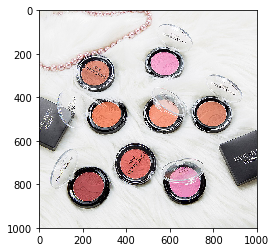

Original: blush on powder glitter matte rouge nude anti air tahan lama
It blongs to: Blush On
Greedy: bedak revlon 2in1
Beam 3:  make over powerstay matte powder foundation


In [217]:
# prediction time
rand_img_idx = 788 # index of a train observation
rand_img_enc =  img_train[rand_img_idx,:,:,:] # readin the image encoding
rand_img_enc = rand_img_enc.reshape((1,) + rand_img_enc.shape) # reshape for modelling
# Read the image path
img_path = df_train.iloc[rand_img_idx].new_path
root_path = '/mnt/disks/NDSC/'
img_path = root_path  + df_train.iloc[rand_img_idx].new_path 
# show the image
x=plt.imread(img_path)
plt.imshow(x)
plt.show()
# predict the captions
cap = df_train.iloc[rand_img_idx].augCap.split()
cap = cap[1:-1]
cap = ' '.join(cap)
print("Original: %s" % cap)
print('It blongs to: %s' % numerical2label[df_train.iloc[rand_img_idx].Category])
print("Greedy:",greedySearch(rand_img_enc, startFlag, endFlag))
print ("Beam 3: ", beam_search(rand_img_enc, startFlag, endFlag, 3, 34))
# print ("Beam 5: ", beam_search(rand_img_enc, startFlag, endFlag, 5, 34))

In [ ]:
### --prediction top five -- ###

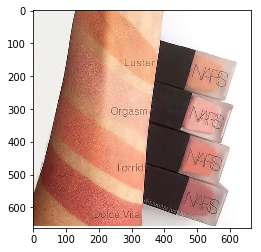

Original: termurah nars liquid blush
It blongs to: Blush On
Greedy: wardah lightening bb cream 30ml
Beam 3:  wardah lightening bb cream 30ml
Beam 5:  maybelline fit me matte poreless powder


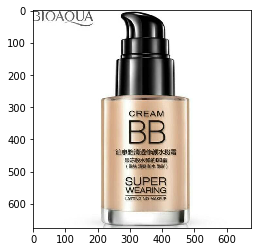

Original: hot produk bioaqua cream bb super wearing lasting no makeup
It blongs to: BB & CC Cream
Greedy: focallure fa30 liquid foundation
Beam 3:  focallure fa30 liquid foundation fa30
Beam 5:  city color oil control matte setting spray make up wajah


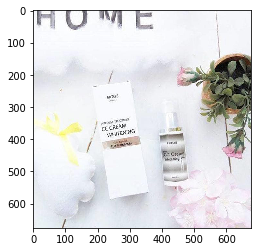

Original: paling murah ertos intensive treatment whitening cc cream pemutih erto s original
It blongs to: BB & CC Cream
Greedy: new product ertos cc cream whitening intensive treatment erto s
Beam 3:  etude house precious mineral beautifying block cream matte spf50 pa
Beam 5:  etude house precious mineral bb cream matte spf50 pa


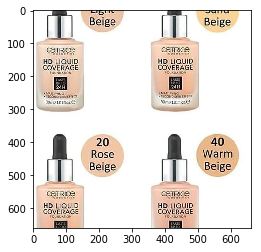

Original: best seller catrice hd liquid coverage fond 30ml
It blongs to: Foundation
Greedy: bioaqua bb cream thin concealer
Beam 3:  focallure big cover liquid concealer
Beam 5:  focallure big cover liquid concealer


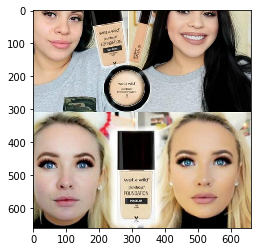

Original: terkini wet n wild photo focus foundation nude ivory
It blongs to: Foundation
Greedy: new collection focallure big cover liquid concealer
Beam 3:  new collection wet n wild photo focus pressed powder neutral buff paling murah promo ramadhan
Beam 5:  make over powerstay matte powder foundation


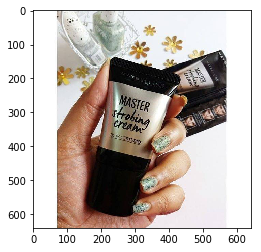

Original: maybelline face studio strobing cream
It blongs to: Highlighter
Greedy: bedak maybelline 2in1
Beam 3:  maybelline fit me matte poreless powder
Beam 5:  maybelline fit me matte poreless powder


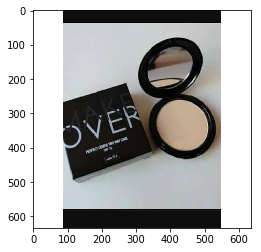

Original: buruan dapetin bedak make over two way cake original
It blongs to: Powder
Greedy: make over silky smooth translucent powder
Beam 3:  make over powerstay matte powder foundation
Beam 5:  nyx stay matte but not flat powder foundation natural smp03


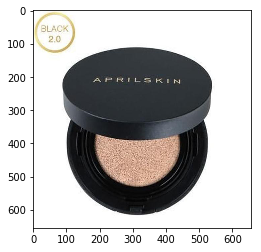

Original: terlaris april skin magic snow cushion black 2.0 new upgrade
It blongs to: Powder
Greedy: focallure loose powder
Beam 3:  make over silky smooth translucent powder bedak tabur
Beam 5:  make over silky smooth translucent powder bedak tabur


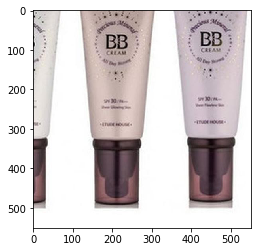

Original: murah etude bb cream
It blongs to: Foundation
Greedy: etude house precious mineral bb cream blooming fit spf30 pa
Beam 3:  etude house precious mineral bb cream blooming fit spf30 pa
Beam 5:  etude house precious mineral bb cream blooming fit spf30 pa


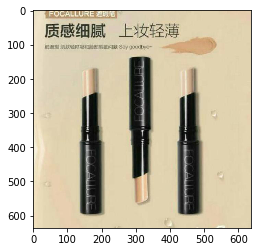

Original: terbaru focallure stick concealer fa 10
It blongs to: Concealer
Greedy: lipstick matte tahan lama dengan pelembab
Beam 3:  bayar di tempat lipstick matte anti air tahan lama dengan pelembab
Beam 5:  etude house play 101 stick contour duo


In [221]:
bot = 8976
top = bot + 10

for i in range(bot,top):
    rand_img_idx = i # index of a train observation
    rand_img_enc =  img_train[rand_img_idx,:,:,:] # readin the image encoding
    rand_img_enc = rand_img_enc.reshape((1,) + rand_img_enc.shape) # reshape for modelling
    # Read the image path
    img_path = df_train.iloc[rand_img_idx].new_path
    root_path = '/mnt/disks/NDSC/'
    img_path = root_path  + df_train.iloc[rand_img_idx].new_path 
    # flag
    startFlag, endFlag = flag_seq(img_path)
    # show the image
    x=plt.imread(img_path)
    plt.imshow(x)
    plt.show()
    # predict the captions
    cap = df_train.iloc[rand_img_idx].augCap.split()
    cap = cap[1:-1]
    cap = ' '.join(cap)
    print("Original: %s" % cap)
    print('It blongs to: %s' % numerical2label[df_train.iloc[rand_img_idx].Category])
    print("Greedy:",greedySearch(rand_img_enc, startFlag, endFlag))
    print ("Beam 3: ", beam_search(rand_img_enc, startFlag, endFlag, 3, 34))
    print ("Beam 5: ", beam_search(rand_img_enc, startFlag, endFlag, 5, 34))

In [218]:
startFlag

'beustart'

In [222]:
df_train_aug = df_train.copy()
df_train_aug['Greedy'] = df_train['title']


In [244]:
# debugging
for i in range(1):
    # rand_img_idx = i # index of a train observation
    rand_img_enc =  img_train[i,:,:,:] # readin the image encoding
    rand_img_enc = rand_img_enc.reshape((1,) + rand_img_enc.shape) # reshape for modelling
    # Read the image path
    img_path = df_train.iloc[rand_img_idx].new_path
    # root_path = '/mnt/disks/NDSC/'
    # img_path = root_path  + df_train.iloc[rand_img_idx].new_path 
    # flag
    startFlag, endFlag = flag_seq(img_path)
    # show the image
    # x=plt.imread(img_path)
    # plt.imshow(x)
    # plt.show()
    # predict the captions
    # cap = df_train.iloc[rand_img_idx].augCap.split()
    # cap = cap[1:-1]
    # cap = ' '.join(cap)
    # print("Original: %s" % cap)
    greedy = greedySearch(rand_img_enc, startFlag, endFlag)
    # print('It blongs to: %s' % numerical2label[df_train.iloc[rand_img_idx].Category])
    # print("Greedy:",greedySearch(rand_img_enc, startFlag, endFlag))
    # print ("Beam 3: ", beam_search(rand_img_enc, startFlag, endFlag, 3, 34))
    # print ("Beam 5: ", beam_search(rand_img_enc, startFlag, endFlag, 5, 34))
    df_train_aug.iloc[i,:].Greedy = greedy

In [224]:
img_path

'Train/Beauty/7/5795fa4afac6223888eecd62daad7ee1.jpg'

In [230]:
df_train_aug.iloc[10:15,:].Greedy

10                          monistat chafing relief gel
11                         milani rose powder blush tea
12                          the balm meet matte trimony
13                 laneige water base cc cream spf36 pa
14    giordani gold age defying compact foundation d...
Name: Greedy, dtype: object

In [271]:
X = temp_train[temp_train.numWord == 4]
X = X.index

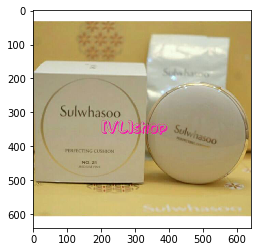

Original: sulwhasoo cushion
It blongs to: Foundation
Greedy: wardah lightening loose powder
Beam 3:  laneige bb cushion pore control spf 50 pa case isi 15gr
Beam 5:  etude house ac clean up mild bb cushion spf50 pa


In [274]:
# prediction time
rand_img_idx = X[1821]  # index of a train observation
rand_img_enc =  img_train[rand_img_idx,:,:,:] # readin the image encoding
rand_img_enc = rand_img_enc.reshape((1,) + rand_img_enc.shape) # reshape for modelling
# Read the image path
img_path = df_train.iloc[rand_img_idx].new_path
startFlag, endFlag = flag_seq(img_path)

root_path = '/mnt/disks/NDSC/'
img_path = root_path  + df_train.iloc[rand_img_idx].new_path 
# show the image
x=plt.imread(img_path)
plt.imshow(x)
plt.show()
# predict the captions
cap = df_train.iloc[rand_img_idx].augCap.split()
cap = cap[1:-1]
cap = ' '.join(cap)
print("Original: %s" % cap)
print('It blongs to: %s' % numerical2label[df_train.iloc[rand_img_idx].Category])
print("Greedy:",greedySearch(rand_img_enc, startFlag, endFlag))
print ("Beam 3: ", beam_search(rand_img_enc, startFlag, endFlag, 3, 34))
print ("Beam 5: ", beam_search(rand_img_enc, startFlag, endFlag, 5, 34))